In [ ]:
#Use Dropout, Normalization, Lower the learning rate, Optimizers to find the best output

In [1]:
! pip uninstall -y kaggle
! pip install --upgrade -q kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 7.2MB/s 


In [2]:
! mkdir -p /root/.kaggle
! cp kaggle.json /root/.kaggle/

In [3]:
import kaggle

In [4]:
! kaggle competitions download -c dog-breed-identification

100% 688M/691M [00:05<00:00, 140MB/s]
100% 691M/691M [00:05<00:00, 123MB/s]


In [5]:
! unzip -q dog-breed-identification.zip

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [7]:
labels = pd.read_csv('labels.csv')

In [8]:
type(labels)

pandas.core.frame.DataFrame

In [9]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


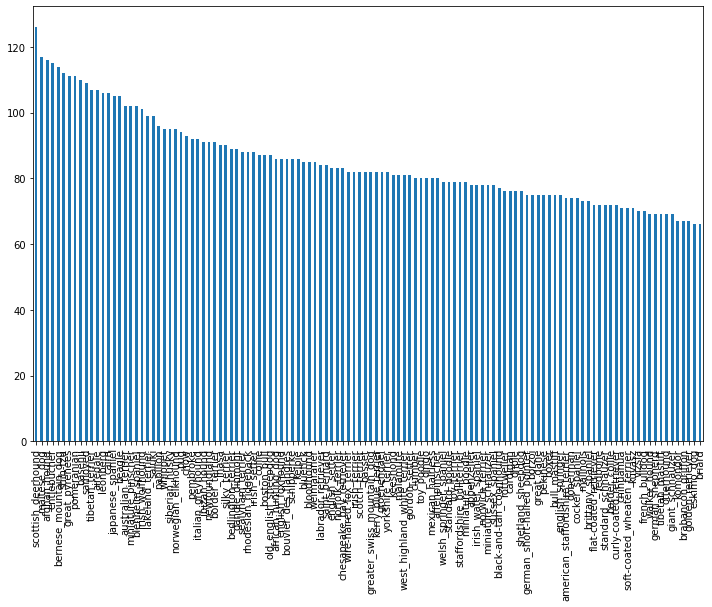

In [10]:
plt.figure(figsize=(12,8))
labels['breed'].value_counts().plot.bar()

In [11]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
labels['id'] = 'train/' + labels['id'] + '.jpg'

In [13]:
labels.tail()

,id,breed
10217,train/ffd25009d635cfd16e793503ac5edef0.jpg,borzoi
10218,train/ffd3f636f7f379c51ba3648a9ff8254f.jpg,dandie_dinmont
10219,train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg,airedale
10220,train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg,miniature_pinscher
10221,train/fff43b07992508bc822f33d8ffd902ae.jpg,chesapeake_bay_retriever


In [14]:
import tensorflow as tf

In [15]:
#Augment the data & pass only 128 at a time (as we have 120 outputs, so pass atlease 120 records)
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, 
                                                      validation_split=0.2, rotation_range=45, horizontal_flip=True)

In [16]:
#As we have already added 'train' to the file names, so folder name 'train' is not required to pass in the below.
train_idg = idg.flow_from_dataframe(labels, x_col='id',y_col='breed', target_size=(224,224), batch_size=128, subset='training')
val_idg = idg.flow_from_dataframe(labels, x_col='id', y_col='breed', target_size=(224,224), batch_size=128, subset='validation')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [17]:
vggmodel = tf.keras.applications.vgg16.VGG16() 

553467904/553467096 [==============================] - 3s 0us/step


In [18]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
#Make the trainable false for all layers & change it for Dense & flatten layer at the later stage. 
for layer in vggmodel.layers:
  layer.trainable = False

In [20]:
for layer in vggmodel.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False
predictions False


In [21]:
#del final_model
#Create functional model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop = tf.keras.layers.Dropout(0.5)(norm)
#Dense output
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop)


NameError: ignored

In [ ]:

final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [ ]:
for layer in final_model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
batch_normalization False
dropout True
dense True


In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.Adagrad(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_modelhist = final_model.fit(train_idg, epochs = 20, validation_data=val_idg)

Epoch 1/20
64/64 [==============================] - 151s 2s/step - loss: 18.9029 - acc: 0.0239 - val_loss: 7.2497 - val_acc: 0.1355
Epoch 2/20
64/64 [==============================] - 135s 2s/step - loss: 12.2152 - acc: 0.0962 - val_loss: 5.5593 - val_acc: 0.2583
Epoch 3/20
64/64 [==============================] - 135s 2s/step - loss: 9.7006 - acc: 0.1707 - val_loss: 4.6789 - val_acc: 0.3141
Epoch 4/20
64/64 [==============================] - 134s 2s/step - loss: 8.6091 - acc: 0.2107 - val_loss: 4.2223 - val_acc: 0.3630
Epoch 5/20
64/64 [==============================] - 134s 2s/step - loss: 7.8801 - acc: 0.2483 - val_loss: 4.0072 - val_acc: 0.3968
Epoch 6/20
64/64 [==============================] - 135s 2s/step - loss: 7.2131 - acc: 0.2809 - val_loss: 3.7636 - val_acc: 0.4149
Epoch 7/20
64/64 [==============================] - 135s 2s/step - loss: 6.8587 - acc: 0.2996 - val_loss: 3.6425 - val_acc: 0.4413
Epoch 8/20
64/64 [==============================] - 135s 2s/step - loss: 6.4428 -

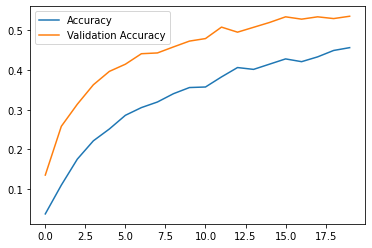

In [ ]:
plt.plot(final_modelhist.history.get('acc'), label='Accuracy')
plt.plot(final_modelhist.history.get('val_acc'), label='Validation Accuracy')
plt.legend()
plt.show()

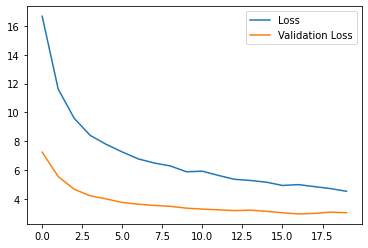

In [ ]:
plt.plot(final_modelhist.history.get('loss'), label='Loss')
plt.plot(final_modelhist.history.get('val_loss'), label='Validation Loss')
plt.legend()
plt.show()

Model2:

In [ ]:
#Try with Shivam's model but with exponential learning rate drop & SGD


import math
def dec_lr(epoch):
  initial_lr =0.01
  drop = 0.5
  epoch_drop = 3
  #lr_rate = initial_lr*drop# if overfitting is high at later stage
  lr_rate = initial_lr * math.pow(drop, math.floor(1+epoch)/epoch_drop) #exponential if overfitting is high at the start itself.
  return lr_rate
  
lrs = tf.keras.callbacks.LearningRateScheduler(dec_lr) #use in call backs of model.fit



In [ ]:
del final_model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop = tf.keras.layers.Dropout(0.5)(norm)
#Dense output
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop)


In [ ]:
final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [ ]:

final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

final_model_hist = final_model.fit(train_idg,epochs=20,validation_data = val_idg,callbacks=[lrs] )

Epoch 1/20
64/64 [==============================] - 138s 2s/step - loss: 14.4715 - acc: 0.1189 - val_loss: 3.9434 - val_acc: 0.4868
Epoch 2/20
64/64 [==============================] - 136s 2s/step - loss: 5.8787 - acc: 0.4095 - val_loss: 3.5389 - val_acc: 0.5455
Epoch 3/20
64/64 [==============================] - 135s 2s/step - loss: 4.6816 - acc: 0.4926 - val_loss: 3.2117 - val_acc: 0.5538
Epoch 4/20
64/64 [==============================] - 136s 2s/step - loss: 4.2277 - acc: 0.5293 - val_loss: 3.0250 - val_acc: 0.5861
Epoch 5/20
64/64 [==============================] - 136s 2s/step - loss: 3.7062 - acc: 0.5687 - val_loss: 3.0178 - val_acc: 0.5861
Epoch 6/20
64/64 [==============================] - 137s 2s/step - loss: 3.4248 - acc: 0.5712 - val_loss: 2.9078 - val_acc: 0.5866
Epoch 7/20
64/64 [==============================] - 136s 2s/step - loss: 3.2785 - acc: 0.5902 - val_loss: 2.9338 - val_acc: 0.5974
Epoch 8/20
64/64 [==============================] - 136s 2s/step - loss: 3.2393 - 

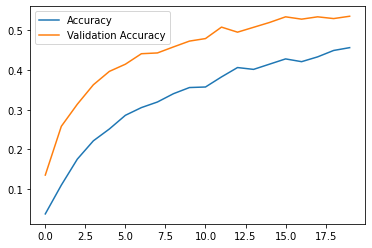

In [ ]:
plt.plot(final_modelhist.history.get('acc'), label='Accuracy')
plt.plot(final_modelhist.history.get('val_acc'), label='Validation Accuracy')
plt.legend()
plt.show()

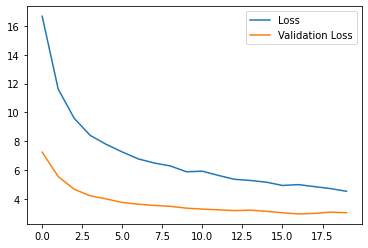

In [ ]:
plt.plot(final_modelhist.history.get('loss'), label='Loss')
plt.plot(final_modelhist.history.get('val_loss'), label='Validation Loss')
plt.legend()
plt.show()

MODEL3 : Try Shivam's model with RMSProp

In [ ]:
del final_model
vggoutput = vggmodel.layers[-3].output
norm = tf.keras.layers.BatchNormalization(trainable=False)(vggoutput)
drop = tf.keras.layers.Dropout(0.5)(norm)
dense_output = tf.keras.layers.Dense(120, activation='softmax')(drop)

In [ ]:
final_model = tf.keras.models.Model(inputs = [vggmodel.input],
                                    outputs = [dense_output])

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg, epochs=30, validation_data=val_idg)

Epoch 1/30
64/64 [==============================] - 152s 2s/step - loss: 12.9262 - acc: 0.1684 - val_loss: 3.8807 - val_acc: 0.5171
Epoch 2/30
64/64 [==============================] - 135s 2s/step - loss: 5.5093 - acc: 0.4605 - val_loss: 3.9750 - val_acc: 0.5445
Epoch 3/30
64/64 [==============================] - 135s 2s/step - loss: 4.1360 - acc: 0.5607 - val_loss: 3.7939 - val_acc: 0.5846
Epoch 4/30
64/64 [==============================] - 135s 2s/step - loss: 3.5203 - acc: 0.6123 - val_loss: 3.6108 - val_acc: 0.6003
Epoch 5/30
64/64 [==============================] - 135s 2s/step - loss: 3.0789 - acc: 0.6568 - val_loss: 3.7142 - val_acc: 0.5983
Epoch 6/30
64/64 [==============================] - 135s 2s/step - loss: 2.8694 - acc: 0.6725 - val_loss: 3.8143 - val_acc: 0.6057
Epoch 7/30
64/64 [==============================] - 135s 2s/step - loss: 2.4992 - acc: 0.7080 - val_loss: 4.1630 - val_acc: 0.6159
Epoch 8/30
64/64 [==============================] - 135s 2s/step - loss: 2.3838 - 

Model4: Try Adam with one extra layer of Dense

In [ ]:
#del final_model
#Create functional model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm1 = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(drop1)
norm2 = tf.keras.layers.BatchNormalization()(dense2)
drop2 = tf.keras.layers.Dropout(0.3)(norm2)
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop2)

In [ ]:
final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.Adam() ,
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])


In [ ]:
final_modelhist = final_model.fit(train_idg, epochs = 20, validation_data=val_idg)

Epoch 1/20
64/64 [==============================] - 137s 2s/step - loss: 4.5353 - acc: 0.0715 - val_loss: 2.7389 - val_acc: 0.3478
Epoch 2/20
64/64 [==============================] - 135s 2s/step - loss: 3.0043 - acc: 0.3517 - val_loss: 2.1074 - val_acc: 0.5059
Epoch 3/20
64/64 [==============================] - 134s 2s/step - loss: 2.3806 - acc: 0.4685 - val_loss: 1.8122 - val_acc: 0.5773
Epoch 4/20
64/64 [==============================] - 135s 2s/step - loss: 2.0236 - acc: 0.5386 - val_loss: 1.6401 - val_acc: 0.6096
Epoch 5/20
64/64 [==============================] - 134s 2s/step - loss: 1.7549 - acc: 0.5853 - val_loss: 1.5190 - val_acc: 0.6130
Epoch 6/20
64/64 [==============================] - 134s 2s/step - loss: 1.5702 - acc: 0.6162 - val_loss: 1.4384 - val_acc: 0.6306
Epoch 7/20
64/64 [==============================] - 134s 2s/step - loss: 1.4574 - acc: 0.6282 - val_loss: 1.3721 - val_acc: 0.6497
Epoch 8/20
64/64 [==============================] - 134s 2s/step - loss: 1.3498 - a

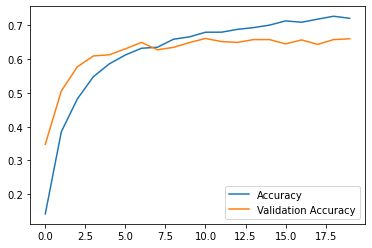

In [ ]:

plt.plot(final_modelhist.history.get('acc'), label='Accuracy')
plt.plot(final_modelhist.history.get('val_acc'), label='Validation Accuracy')
plt.legend()
plt.show()


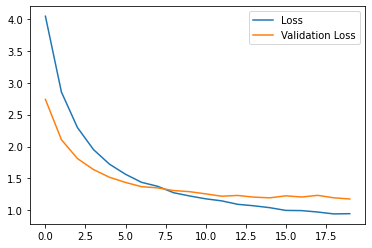

In [ ]:
plt.plot(final_modelhist.history.get('loss'), label='Loss')
plt.plot(final_modelhist.history.get('val_loss'), label='Validation Loss')
plt.legend()
plt.show()

MODEL 5: Increase the neurons to 128 and then run the Adam again

In [25]:
#del final_model
#Create functional model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm1 = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
norm2 = tf.keras.layers.BatchNormalization()(dense2)
drop2 = tf.keras.layers.Dropout(0.3)(norm2)
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop2)


In [26]:
final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [28]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [29]:
final_modelhist = final_model.fit(train_idg, epochs = 20, validation_data=val_idg)

Epoch 1/20
64/64 [==============================] - 136s 2s/step - loss: 4.3453 - acc: 0.1172 - val_loss: 2.0686 - val_acc: 0.4628
Epoch 2/20
64/64 [==============================] - 126s 2s/step - loss: 2.3081 - acc: 0.4667 - val_loss: 1.5534 - val_acc: 0.6081
Epoch 3/20
64/64 [==============================] - 126s 2s/step - loss: 1.7415 - acc: 0.5787 - val_loss: 1.4218 - val_acc: 0.6184
Epoch 4/20
64/64 [==============================] - 126s 2s/step - loss: 1.5040 - acc: 0.6145 - val_loss: 1.3573 - val_acc: 0.6336
Epoch 5/20
64/64 [==============================] - 126s 2s/step - loss: 1.3348 - acc: 0.6542 - val_loss: 1.3043 - val_acc: 0.6414
Epoch 6/20
64/64 [==============================] - 126s 2s/step - loss: 1.1987 - acc: 0.6807 - val_loss: 1.2559 - val_acc: 0.6610
Epoch 7/20
64/64 [==============================] - 125s 2s/step - loss: 1.1288 - acc: 0.6957 - val_loss: 1.2459 - val_acc: 0.6600
Epoch 8/20
64/64 [==============================] - 126s 2s/step - loss: 1.0128 - a

Model 6: As Dense layer with 120 is overfitting, so try with two layers 64 & 32.

In [35]:
del final_model
#Create functional model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm1 = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(drop1)
norm2 = tf.keras.layers.BatchNormalization()(dense2)
drop2 = tf.keras.layers.Dropout(0.3)(norm2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
norm3 = tf.keras.layers.BatchNormalization()(dense3)
drop3 = tf.keras.layers.Dropout(0.3)(norm3)
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop3)

In [36]:
final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [37]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [38]:
final_modelhist = final_model.fit(train_idg, epochs = 40, validation_data=val_idg)

Epoch 1/40
64/64 [==============================] - 130s 2s/step - loss: 4.7843 - acc: 0.0210 - val_loss: 3.8608 - val_acc: 0.1311
Epoch 2/40
64/64 [==============================] - 127s 2s/step - loss: 4.0932 - acc: 0.1217 - val_loss: 3.3582 - val_acc: 0.2808
Epoch 3/40
64/64 [==============================] - 127s 2s/step - loss: 3.6485 - acc: 0.2150 - val_loss: 3.0051 - val_acc: 0.3699
Epoch 4/40
64/64 [==============================] - 126s 2s/step - loss: 3.3092 - acc: 0.2580 - val_loss: 2.6606 - val_acc: 0.4305
Epoch 5/40
64/64 [==============================] - 127s 2s/step - loss: 2.9514 - acc: 0.3267 - val_loss: 2.3957 - val_acc: 0.4765
Epoch 6/40
64/64 [==============================] - 127s 2s/step - loss: 2.7274 - acc: 0.3483 - val_loss: 2.1463 - val_acc: 0.5073
Epoch 7/40
64/64 [==============================] - 127s 2s/step - loss: 2.4726 - acc: 0.4025 - val_loss: 1.9627 - val_acc: 0.5284
Epoch 8/40
64/64 [==============================] - 126s 2s/step - loss: 2.3470 - a

**MODEL8** : Train the last 3 layers of vgg and add our own dense layers. Also keep training rate 0.005

In [ ]:
vggmodel = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

In [ ]:
#Train the last 3 layers in VGG & slow down the learning rate in SGD
for layer in vggmodel.layers:
  print(layer.name, layer.trainable)

input_4 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
for layer in vggmodel.layers:
  layer.trainable=False

In [ ]:
for layer in vggmodel.layers:
  if 'block5' in layer.name:
    layer.trainable = True

In [ ]:
for layer in vggmodel.layers:
  print(layer.name, layer.trainable)

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
#Create our dense layer
del final_model
vgg_output = vggmodel.output
flatten_output = tf.keras.layers.Flatten()(vgg_output)
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(flatten_output)
norm1 = tf.keras.layers.BatchNormalization()(dense1)
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense_output = tf.keras.layers.Dense(120, activation='softmax')(drop1)

In [ ]:

final_model = tf.keras.models.Model(inputs = [vggmodel.input],
                                    outputs =[dense_output])

In [ ]:
final_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=30,validation_data = val_idg)

Epoch 1/30
64/64 [==============================] - 140s 2s/step - loss: 5.4007 - acc: 0.0310 - val_loss: 3.8264 - val_acc: 0.1820
Epoch 2/30
64/64 [==============================] - 136s 2s/step - loss: 3.6388 - acc: 0.1764 - val_loss: 2.8406 - val_acc: 0.3141
Epoch 3/30
64/64 [==============================] - 136s 2s/step - loss: 2.9986 - acc: 0.2874 - val_loss: 2.5115 - val_acc: 0.3855
Epoch 4/30
64/64 [==============================] - 136s 2s/step - loss: 2.6127 - acc: 0.3619 - val_loss: 2.3012 - val_acc: 0.4271
Epoch 5/30
64/64 [==============================] - 136s 2s/step - loss: 2.3800 - acc: 0.4107 - val_loss: 2.1840 - val_acc: 0.4545
Epoch 6/30
64/64 [==============================] - 136s 2s/step - loss: 2.1625 - acc: 0.4624 - val_loss: 2.0338 - val_acc: 0.5015
Epoch 7/30
64/64 [==============================] - 136s 2s/step - loss: 2.0360 - acc: 0.4812 - val_loss: 1.9612 - val_acc: 0.5171
Epoch 8/30
64/64 [==============================] - 137s 2s/step - loss: 1.8797 - a

Model9 : Adagard with the above style

In [ ]:
del final_model
vgg_output = vggmodel.output
flatten_output = tf.keras.layers.Flatten()(vgg_output)
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(flatten_output)
norm1 = tf.keras.layers.BatchNormalization()(dense1)
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense_output = tf.keras.layers.Dense(120, activation='softmax')(drop1)

In [ ]:

final_model = tf.keras.models.Model(inputs = [vggmodel.input],
                                    outputs =[dense_output])

In [ ]:

final_model.compile(optimizer=tf.keras.optimizers.Adagrad(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=30,validation_data = val_idg)

Epoch 1/30
64/64 [==============================] - 139s 2s/step - loss: 5.2293 - acc: 0.0455 - val_loss: 3.5754 - val_acc: 0.2128
Epoch 2/30
64/64 [==============================] - 135s 2s/step - loss: 3.3633 - acc: 0.2312 - val_loss: 2.6495 - val_acc: 0.3615
Epoch 3/30
64/64 [==============================] - 135s 2s/step - loss: 2.7243 - acc: 0.3420 - val_loss: 2.3938 - val_acc: 0.4276
Epoch 4/30
64/64 [==============================] - 136s 2s/step - loss: 2.3543 - acc: 0.4279 - val_loss: 2.2317 - val_acc: 0.4746
Epoch 5/30
64/64 [==============================] - 136s 2s/step - loss: 2.1386 - acc: 0.4691 - val_loss: 2.0513 - val_acc: 0.5127
Epoch 6/30
64/64 [==============================] - 137s 2s/step - loss: 1.8937 - acc: 0.5370 - val_loss: 1.9517 - val_acc: 0.5137
Epoch 7/30
64/64 [==============================] - 137s 2s/step - loss: 1.8302 - acc: 0.5511 - val_loss: 1.9360 - val_acc: 0.5328
Epoch 8/30
64/64 [==============================] - 136s 2s/step - loss: 1.6903 - a

Model5: RMSProp

In [ ]:
del final_model
vgg_output = vggmodel.output
flatten_output = tf.keras.layers.Flatten()(vgg_output)
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(flatten_output)
norm1 = tf.keras.layers.BatchNormalization()(dense1)
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense_output = tf.keras.layers.Dense(120, activation='softmax')(drop1)

In [ ]:

final_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=30,validation_data = val_idg) #Stopped as it was overfitting

60/64 [===========================>..] - ETA: 6s - loss: 0.4016 - acc: 0.8769

KeyboardInterrupt: ignored

Model10: Reduce the learning rate by using callback & use it

In [ ]:
import math
def dec_lr(epoch):
  initial_lr =0.01
  drop = 0.5
  epoch_drop = 3
  lr_rate = initial_lr*drop# if overfitting is high at later stage
  #lr_rate = inital_lr * math.pow(drop, math.floor(1+epoch)/epoch_drop) #exponential if overfitting is high at the start itself.
  return lr_rate

In [ ]:
lrs = tf.keras.callbacks.LearningRateScheduler(dec_lr) #use in call backs of model.fit

In [ ]:
vggmodel = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in vggmodel.layers:
  print(layer.name, layer.trainable)

input_3 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
for layer in vggmodel.layers:
  layer.trainable=False

In [ ]:
for layer in vggmodel.layers:
  if 'block5' in layer.name:
    layer.trainable = True

In [ ]:
for layer in vggmodel.layers:
  print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
vgg_output = vggmodel.output
flatten_output = tf.keras.layers.Flatten()(vgg_output)
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(flatten_output)
norm1 = tf.keras.layers.BatchNormalization()(dense1)
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense_output = tf.keras.layers.Dense(120, activation='softmax')(drop1)

In [ ]:
del final_model
final_model = tf.keras.models.Model(inputs = [vggmodel.input],
                                    outputs =[dense_output])

In [ ]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=20,validation_data = val_idg,callbacks=[lrs] )

Epoch 1/20
64/64 [==============================] - 138s 2s/step - loss: 2.3575 - acc: 0.4085 - val_loss: 2.1623 - val_acc: 0.4633
Epoch 2/20
64/64 [==============================] - 138s 2s/step - loss: 2.1680 - acc: 0.4549 - val_loss: 2.1051 - val_acc: 0.4892
Epoch 3/20
64/64 [==============================] - 138s 2s/step - loss: 1.9896 - acc: 0.4946 - val_loss: 2.0005 - val_acc: 0.5137
Epoch 4/20
64/64 [==============================] - 138s 2s/step - loss: 1.8647 - acc: 0.5290 - val_loss: 1.9137 - val_acc: 0.5386
Epoch 5/20
64/64 [==============================] - 138s 2s/step - loss: 1.7476 - acc: 0.5573 - val_loss: 1.8531 - val_acc: 0.5313
Epoch 6/20
64/64 [==============================] - 139s 2s/step - loss: 1.6586 - acc: 0.5750 - val_loss: 1.7814 - val_acc: 0.5528
Epoch 7/20
64/64 [==============================] - 138s 2s/step - loss: 1.5615 - acc: 0.6030 - val_loss: 1.7522 - val_acc: 0.5514
Epoch 8/20
64/64 [==============================] - 137s 2s/step - loss: 1.4678 - a

Model11: Exponential

In [ ]:
import math
def dec_lr(epoch):
  initial_lr =0.01
  drop = 0.5
  epoch_drop = 3
  #lr_rate = initial_lr*drop# if overfitting is high at later stage
  lr_rate = initial_lr * math.pow(drop, math.floor(1+epoch)/epoch_drop) #exponential if overfitting is high at the start itself.
  return lr_rate

In [ ]:
lrs = tf.keras.callbacks.LearningRateScheduler(dec_lr) #use in call backs of model.fit

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=20,validation_data = val_idg,callbacks=[lrs] )

Epoch 1/20
64/64 [==============================] - 143s 2s/step - loss: 0.7373 - acc: 0.8226 - val_loss: 1.4714 - val_acc: 0.5930
Epoch 2/20
64/64 [==============================] - 140s 2s/step - loss: 0.6774 - acc: 0.8399 - val_loss: 1.4969 - val_acc: 0.5993
Epoch 3/20
64/64 [==============================] - 140s 2s/step - loss: 0.6495 - acc: 0.8487 - val_loss: 1.4360 - val_acc: 0.6130
Epoch 4/20
64/64 [==============================] - 140s 2s/step - loss: 0.6175 - acc: 0.8531 - val_loss: 1.4590 - val_acc: 0.6023
Epoch 5/20
64/64 [==============================] - 140s 2s/step - loss: 0.5855 - acc: 0.8678 - val_loss: 1.4324 - val_acc: 0.6189
Epoch 6/20
64/64 [==============================] - 140s 2s/step - loss: 0.5691 - acc: 0.8717 - val_loss: 1.4103 - val_acc: 0.6140
Epoch 7/20
64/64 [==============================] - 140s 2s/step - loss: 0.5651 - acc: 0.8754 - val_loss: 1.4235 - val_acc: 0.6199
Epoch 8/20
64/64 [==============================] - 139s 2s/step - loss: 0.5261 - a

Model12 : VGG, exponential drop in learning rate + 2 dense layers of mine

In [21]:

import math
def dec_lr(epoch):
  initial_lr =0.01
  drop = 0.5
  epoch_drop = 3
  #lr_rate = initial_lr*drop# if overfitting is high at later stage
  lr_rate = initial_lr * math.pow(drop, math.floor(1+epoch)/epoch_drop) #exponential if overfitting is high at the start itself.
  return lr_rate


In [22]:
lrs = tf.keras.callbacks.LearningRateScheduler(dec_lr)

In [24]:
#del final_model
#Create functional model
vggoutput = vggmodel.layers[-3].output #Take the output of vggmodel but leave the last 3.
#Normalize the output of the vggmodel
norm1 = tf.keras.layers.BatchNormalization(trainable=False) (vggoutput) #Always make trainable False for batch
#Dropout some of the neurons randomly with each epoch. This will help reduce the overfitting
drop1 = tf.keras.layers.Dropout(0.5)(norm1)
dense2 = tf.keras.layers.Dense(64, activation='relu')(drop1)
norm2 = tf.keras.layers.BatchNormalization()(dense2)
drop2 = tf.keras.layers.Dropout(0.5)(norm2)
dense3 = tf.keras.layers.Dense(32, activation='relu')(drop2)
norm3 = tf.keras.layers.BatchNormalization()(dense3)
drop3 = tf.keras.layers.Dropout(0.3)(norm3)
dense_output = tf.keras.layers.Dense(120,activation='softmax')(drop3)

In [25]:
final_model = tf.keras.models.Model(inputs=[vggmodel.input], outputs = [dense_output])

In [27]:
final_model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss = tf.keras.losses.categorical_crossentropy,
                    metrics = ['acc'])

In [ ]:
final_model_hist = final_model.fit(train_idg,epochs=40,validation_data = val_idg,callbacks=[lrs] )

Epoch 1/40
64/64 [==============================] - 152s 2s/step - loss: 5.0492 - acc: 0.0080 - val_loss: 4.7538 - val_acc: 0.0240
Epoch 2/40
64/64 [==============================] - 134s 2s/step - loss: 4.9564 - acc: 0.0117 - val_loss: 4.6475 - val_acc: 0.0401
Epoch 3/40
64/64 [==============================] - 133s 2s/step - loss: 4.8557 - acc: 0.0157 - val_loss: 4.5972 - val_acc: 0.0484
Epoch 4/40
64/64 [==============================] - 134s 2s/step - loss: 4.8103 - acc: 0.0234 - val_loss: 4.5650 - val_acc: 0.0543
Epoch 5/40
64/64 [==============================] - 133s 2s/step - loss: 4.7815 - acc: 0.0215 - val_loss: 4.5380 - val_acc: 0.0631
Epoch 6/40
64/64 [==============================] - 134s 2s/step - loss: 4.7568 - acc: 0.0208 - val_loss: 4.5237 - val_acc: 0.0709
Epoch 7/40
64/64 [==============================] - 133s 2s/step - loss: 4.7393 - acc: 0.0272 - val_loss: 4.5070 - val_acc: 0.0734
Epoch 8/40
64/64 [==============================] - 133s 2s/step - loss: 4.6991 - a